## Analyze degenerate barcodes
20221006 - Meant to be run after processing of unmapped reads (generated by CellRanger) using Picard / Samtools

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pysam
import scipy.stats

from Bio import SeqIO

np.random.seed(5)

In [2]:
hashes = {}
import csv
with open('barcodes.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    #first column forward, second column reverse complement
    for row in csvreader:
        if row[0].startswith("#"): continue
        hashes[row[0]] = row[2]

In [3]:
hashes

{'TGTCTAGT': 'shRenilla-1',
 'CTGAATCT': 'Myc (63)',
 'TTAATTAG': 'Onecut2 (76)',
 'CGGGAATG': 'Fosl2 (60)',
 'GCCTACGT': 'Fhl2 (61)',
 'GCCAATCG': 'Itga2 (1811)',
 'CGTTTCCT': 'Cldn4 (1999)',
 'ACACGTGA': 'Lif (2114)',
 'CAGTGCAT': 'Nfkb1 (2118)',
 'CGTTAGGG': 'Yap1 (65)',
 'CGTTCAAG': 'Nfkb2 (71)',
 'GGTAGGGA': 'Fosl1 (2115)',
 'ACAGAGCC': 'Relb (73) ',
 'GTACTTGC': 'patch4.4-1',
 'CCATTACT': 'patch4.4-2',
 'CATAGTCA': 'shRenilla-2',
 'TCTGGGGC': 'Atf4 (67)'}

In [4]:
#hashes = {"TGTCTAGT": "shRenilla", "CTGAATCT": "shMyc(63)", "TTAATTAG": "shOnecut2(76)"}
hashmatch = re.compile('GT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AA') #forward
#hashmatch = re.compile('TT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AC') #reverse complement

In [5]:
def hammingDistance(a, b):
    return sum(str1 != str2 for str1, str2 in zip(a, b))

In [6]:
#Changed this to actual experimental whitelist
import pickle
whitelist = set()
#open whitelist
with open('../write/cellwhitelist0.pickle', 'rb') as f:
    whitelist = pickle.load(f)

In [7]:
print(len(whitelist))

7114


In [8]:
afile = pysam.AlignmentFile("./final_0.6.bam")
hashcount = {}
hashset = {}
cellhash = {}
taghash = {}
readcount = {}
barcodehash = {} # barcodes listing shRNAID
barcodebycellUMI = {} # barcode listing cellUMI
doublecounts = 0
cellbyUMI = {}
inwhitelist = set()
inwhitelistcount = 0
outwhitelist = set()
outwhitelistcount = 0
for seq_record in afile.fetch(until_eof=True):
    cellUMI = None  # here this is the CellRanger cell UMI
    UMI = None
    if not seq_record.has_tag("CB") or not seq_record.has_tag("UB"): continue
    cellUMI = seq_record.get_tag("CB")
    if cellUMI not in whitelist: 
        outwhitelistcount +=1
        if cellUMI not in outwhitelist: outwhitelist.add(cellUMI)
        continue
    else:
        inwhitelistcount += 1
        if cellUMI not in inwhitelist: inwhitelist.add(cellUMI)
    UMI = seq_record.get_tag("UB") # umi barcode
    
    m = hashmatch.search(seq_record.query_sequence)
    if m == None or (m.end() + 8) > len(seq_record.query_sequence):
        #print("Error, match not found")
        continue
    shRNAID = seq_record.query_sequence[m.end():m.end()+8]
    barcode = seq_record.query_sequence[m.end()-21:m.end()]
    sbID = (shRNAID,barcode)
    if shRNAID not in hashes: continue
    if cellUMI not in cellbyUMI:
        cellbyUMI[cellUMI] = {}
    if UMI not in cellbyUMI[cellUMI]:
        cellbyUMI[cellUMI][UMI] = {sbID: 1}
        continue
    if sbID in cellbyUMI[cellUMI][UMI]:
        cellbyUMI[cellUMI][UMI][sbID] += 1
    else:
        hamming = False
        for x in cellbyUMI[cellUMI][UMI]:
            if hammingDistance(sbID[1],x[1]) <= 2:
                cellbyUMI[cellUMI][UMI][x] += 1
                hamming = True
                break
        if hamming: continue
        cellbyUMI[cellUMI][UMI][sbID] = 1


## IGNORE THIS

## END IGNORE

In [9]:
from IPython.core.debugger import set_trace

In [10]:
# first pass generate histogram of counts
histogram_of_counts = []
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        histogram_of_counts.extend(cellbyUMI[UMI][y].values())

By UMI/Cell


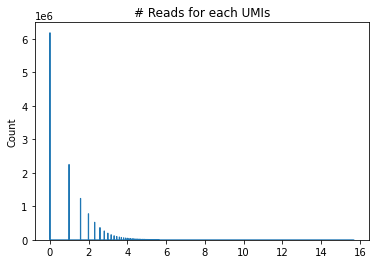

In [11]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
#cutoff = _[1][1]
#plt.axvline(x=cutoff)
plt.show()

In [12]:
_

(array([6.181359e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.249269e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

In [13]:
count = 0
for x in range(0,len(_[1])):
    if x == 0: continue
    if round(_[1][x]) >= 4:
        count = x
        break

In [14]:
count

207

By UMI/Cell


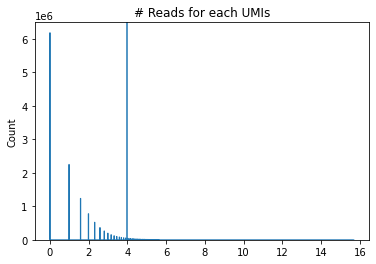

In [15]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff = round(_[1][count])
plt.axvline(x=cutoff)
plt.show()

In [16]:
cutoff = 2**(round(cutoff))
print(cutoff)

16


In [17]:
# Cleanup, prune any reads that don't pass the cutoff
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        toRemove = []
        for z in cellbyUMI[UMI][y]:
            if cellbyUMI[UMI][y][z] <= cutoff: toRemove.append(z)
        for z in toRemove:
            del cellbyUMI[UMI][y][z]
    toRemove = []
    for y in cellbyUMI[UMI]:
        if len(cellbyUMI[UMI][y]) == 0: toRemove.append(y)
    for y in toRemove:
        del cellbyUMI[UMI][y]
toRemove = []
for UMI in cellbyUMI:
    if len(cellbyUMI[UMI]) == 0: toRemove.append(UMI)
for UMI in toRemove:
    del cellbyUMI[UMI]

## second pass onwards

## end pass

In [18]:
## counting total UMIs from dominant shRNA
histogram_of_UMIs = []
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] >= threshold: ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
  
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]       
        else:
            print(newUMI)
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        continue            
            
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    histogram_of_UMIs.extend(UMIpairs.values())
    continue
    
    
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1 and list(UMIpairs.values())[0] >= 5:
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort()
    newUMI.reverse()
    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI if z[0] >= 5])

#    set_trace()
    if newUMI[0][0] < 5: continue
    if len(newUMI) == 2: # newUMI = [(count, (shRNAID, barcode)), ...]
        if newUMI[0][0] - newUMI[1][0] >= 3 and newUMI[1][0] <= 3:
            assignedCellshRNA[x] = newUMI[0][1][0]
            assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.15:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    poorUMI.append(newUMI)
    poorUMI2.append(x)

[(22, ('TTAATTAG', 'TTTTCAATGTTTTTATTTTAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(21, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (19, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (17, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(35, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (34, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (33, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (29, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (29, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (25, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (20, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (17, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (17, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(35, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(22, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (21, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (19, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(29,

[(25, ('CGTTCAAG', 'GAGGTAAACATGTTTTAGTAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(27, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(23, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(19, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (17, ('TGTCTAGT', 'GTGGGAATTTCATTGGAGGAA'))]
[(34, ('TGTCTAGT', 'GTGGGAATTTCATTGGAGGAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(21, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (21, ('ACACGTGA', 'GGTGGAATGTGGTTGTGTGAA')), (20, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(29, ('GGTAGGGA', 'TATAGAACAGGGTTAATGTAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(27, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[

[(26, ('CGTTAGGG', 'AGACCAAAGCTTTTACGTCAA')), (25, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA'))]
[(26, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (22, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (21, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (21, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (19, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (19, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (17, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(29, ('TTAATTAG', 'TTTTTAATTATTTTATTTTAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(30, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (20, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(21,

[(32, ('GGTAGGGA', 'TGGGCAATATATTTGTCGTAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(21, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(28, ('TGTCTAGT', 'GGGGGAAGGGGCTTGGGGGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(27, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(30, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA'))]
[(22, ('TTAATTAG', 'GTTTTAATTTTTTTTTTTAAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(30, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(22, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (

[(21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('TGTCTAGT', 'GAAGGAAGAGAGTTAGAAGAA'))]
[(30, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (27, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (26, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(35, ('CGGGAATG', 'TTCTCAATTCTTTTCTTCCAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(25, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (1

[(22, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA'))]
[(28, ('CGTTCAAG', 'TATTCAAATATATTGGTATAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (22, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(18, ('GCCTACGT', 'AAAAAAAAAAAATTTAATAAA')), (17, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(24, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(21, ('GGTAGGGA', 'CTGAAAAGATTGTTCTTTGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(33, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(29, ('TGTCTAGT', 'GGGGGAATGGGGTTGGGGGAA')), (28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (27, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (25, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (2

[(23, ('TGTCTAGT', 'TTTTTAAGCTTTTTTGTTGAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(19, ('CGTTAGGG', 'GAAGGAATCAAATTTAACAAA')), (18, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA'))]
[(25, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(24, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (20, ('TCTGGGGC', 'GCCCCAACCCCCTTCATCTAA'))]
[(20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(29, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[

[(18, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('CGGGAATG', 'GGAGAAATGATGTTAGGAGAA'))]
[(25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA')), (18, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
[(21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(29, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (29, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(25, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(

[(32, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (30, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (29, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (25, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (22, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(32, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (28, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (21, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (21, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (20, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (19, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(32, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (28,

[(28, ('TGTCTAGT', 'GTAGGAATTTTTTTGGGGTAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(28, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(27, ('TGTCTAGT', 'GTAGGAATTTTTTTGGGGTAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
[(29, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (29, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (28, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (26, ('CGGGAATG', 'TTTTTAATTTTTTTTGTTTAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(32, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(23,

[(21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(29, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA'))]
[(26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(25, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(22, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(29, ('CGGGAATG', 'CCCCCAATGCCCTTTGCCAAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
[(27, ('CGTTCAAG', 'TGTTTAATGCATTTTCTTGAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(

In [19]:
print(sum(histogram_of_UMIs))


64094


## END CODE HERE FOR NOW